# Logistic Regression


# Model
<h3>prior</h3>

$\theta \sim Normal( \mathbf{m},\Sigma)$ 

<h3>likelihood</h3>

$samples - Bernoulli(\theta^T\mathbf{x})$

In [2]:
import jax.numpy as jnp
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
import optax
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
import pandas as pd
import jax
key = jax.random.PRNGKey(0)
import logging
import pickle
import blackjax
from rmh import rmh_inference_loop,plot_rmh
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

2022-06-12 22:05:38.838863: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [3]:
with open("../data/logistic_regression_data",'rb') as f:
    data = pickle.load(f)

In [4]:
x = data['data']['x']
x[:,:2] = (x[:,:2]- jax.numpy.min(x,axis = 0)[:2])/(jax.numpy.max(x,axis = 0)[:2]-jax.numpy.min(x, axis = 0)[:2])
prior_mean = data['prior']['loc']
prior_var = data['prior']['covariance_matrix']
y = jnp.array(data['data']['y'])
y = jnp.reshape(y, (y.shape[1],))

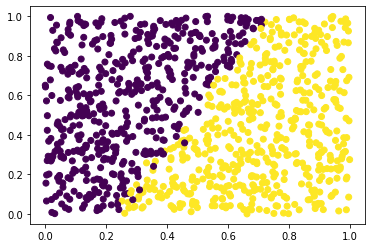

In [5]:
plt.scatter(x[:,0],x[:,1],c=y)

In [6]:

prior_normal = tfd.MultivariateNormalFullCovariance(
    loc= prior_mean,covariance_matrix=prior_var
)
n = 3

In [7]:
m = y.shape[0]
def log_postfn(theta):
    theta = theta['theta']
    log_prior = prior_normal.log_prob(theta)
    logit = (x@theta.reshape(n,1)).reshape((-1))
    likelihood_bern = tfd.Bernoulli(logit)
    log_like = jnp.sum(likelihood_bern.log_prob(y.reshape(-1)))
    return (log_like+log_prior)
theta = {"theta": jnp.array([10.4, 11.4,2.4])}
log_postfn(theta)



DeviceArray(-5774.5044, dtype=float32)

In [8]:

states = rmh_inference_loop(log_postfn,jnp.identity(n) * 0.8,theta,100000)

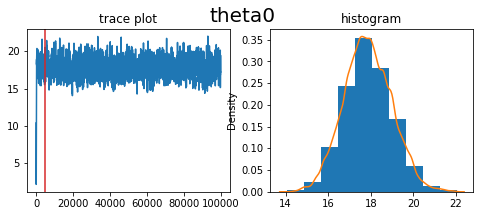

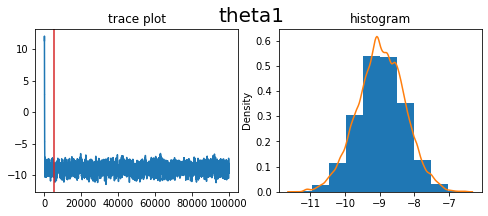

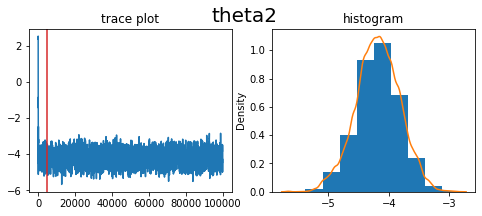

In [9]:
plot_rmh(states,burnin=5000,contains_arrays=True)

In [12]:
with open("../results/logistic_regression/results_data/MCMC_Blackjax",'wb') as f:
    pickle.dump(states,f)